In [1]:
import pandas as pd

# Load the CSV created by the test
df = pd.read_csv("../tests/data/measures/brier_score_breast_cancer.csv")
df

,model,brier_score
0,Logistic Regression,0.025349
1,Random Forest,0.025520
2,Gradient Boosting,0.032814
3,SVC (probabilities),0.034043


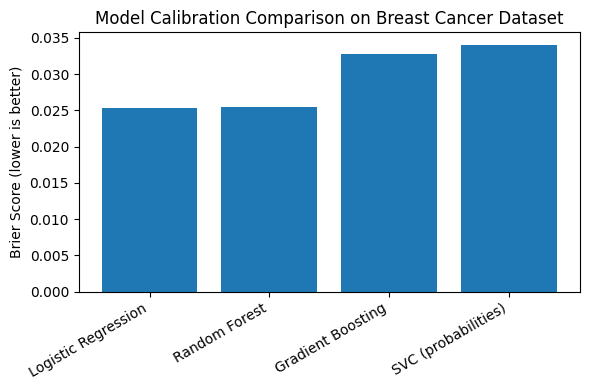

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(df["model"], df["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Model Calibration Comparison on Breast Cancer Dataset")
plt.tight_layout()
plt.show()

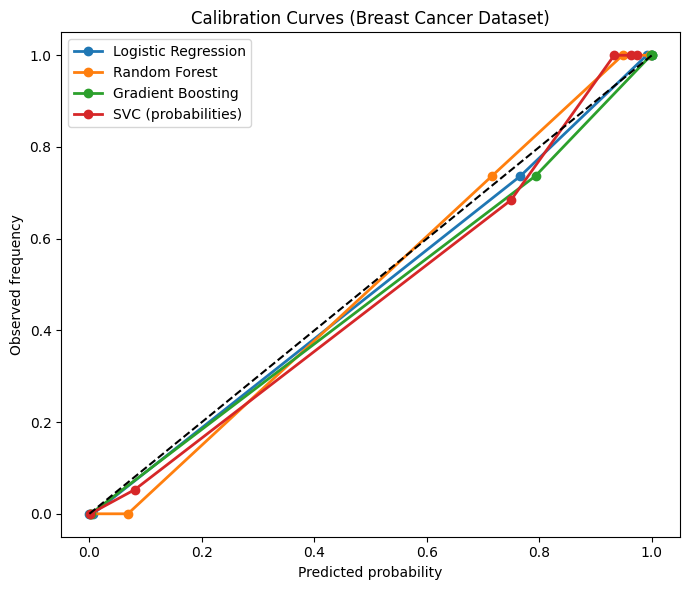

In [5]:
# Cell 3 – Calibration (reliability) curves

plt.figure(figsize=(7, 6))

for name, model in models.items():
    # retrain to be safe (cheap)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    # use quantile bins to avoid crazy zig-zags
    frac_pos, mean_pred_prob = calibration_curve(
        y_test, probs, n_bins=6, strategy="quantile"
    )

    # sort points by predicted probability
    order = np.argsort(mean_pred_prob)

    plt.plot(
        mean_pred_prob[order],
        frac_pos[order],
        marker="o",
        linewidth=2,
        label=name,
    )

# ideal diagonal
plt.plot([0, 1], [0, 1], "--", color="black")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves (Breast Cancer Dataset)")
plt.legend()
plt.tight_layout()
plt.show()

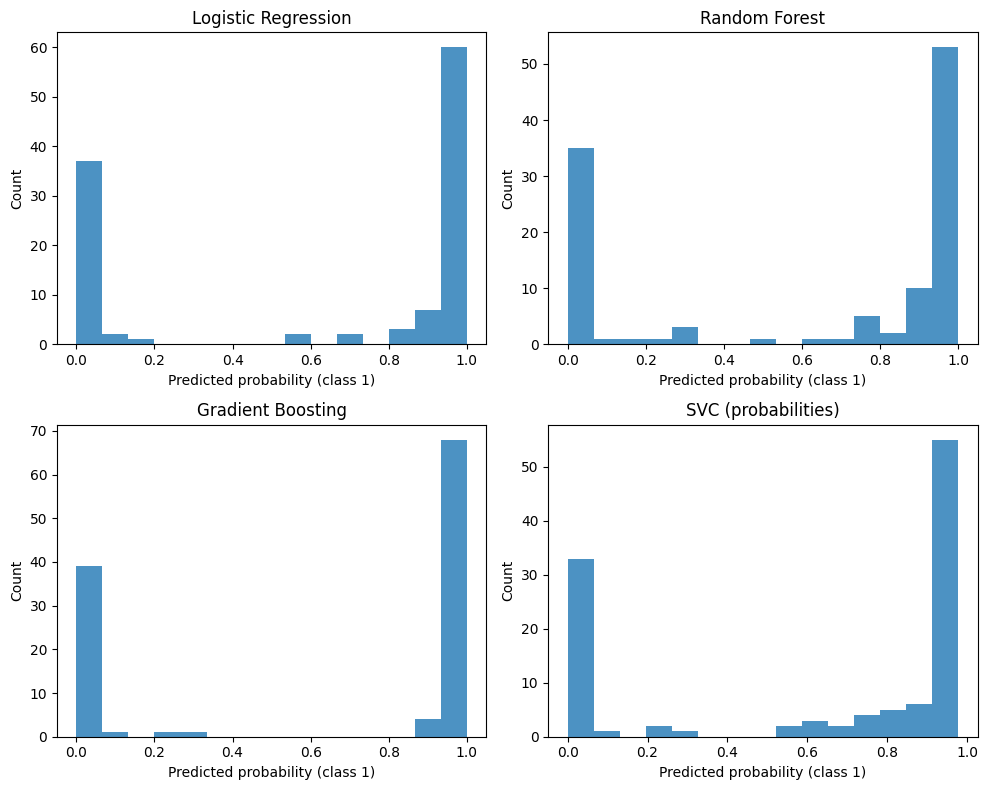

In [6]:
# Cell 4 – Histograms of predicted probabilities (confidence profiles)

plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 2, i + 1)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    plt.hist(probs, bins=15, alpha=0.8)
    plt.title(name)
    plt.xlabel("Predicted probability (class 1)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [5]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_results = []

# We'll calibrate Random Forest and Gradient Boosting
to_calibrate = ["Random Forest", "Gradient Boosting"]

for name in to_calibrate:
    base_model = models[name]

    # Wrap the model with a calibrator (isotonic or sigmoid)
    calib = CalibratedClassifierCV(base_model, method="isotonic", cv=3)

    # Fit on training data
    calib.fit(X_train, y_train)

    # Evaluate on test data
    y_pred = calib.predict(X_test)
    y_proba = calib.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_proba)

    calibrated_results.append(
        {
            "model": name + " (calibrated)",
            "accuracy": acc,
            "brier_score": brier,
        }
    )

df_calibrated = pd.DataFrame(calibrated_results)
df_calibrated

,model,accuracy,brier_score
0,Random Forest (calibrated),0.964912,0.022643
1,Gradient Boosting (calibrated),0.956140,0.032713


In [6]:
df_all = pd.concat([df_metrics, df_calibrated], ignore_index=True)
df_all_sorted = df_all.sort_values("brier_score")

df_all_sorted

,model,accuracy,brier_score
4,Random Forest (calibrated),0.964912,0.022643
0,Logistic Regression,0.956140,0.025200
1,Random Forest,0.964912,0.026130
2,Gradient Boosting,0.956140,0.032131
5,Gradient Boosting (calibrated),0.956140,0.032713
3,SVC (probabilities),0.947368,0.034622


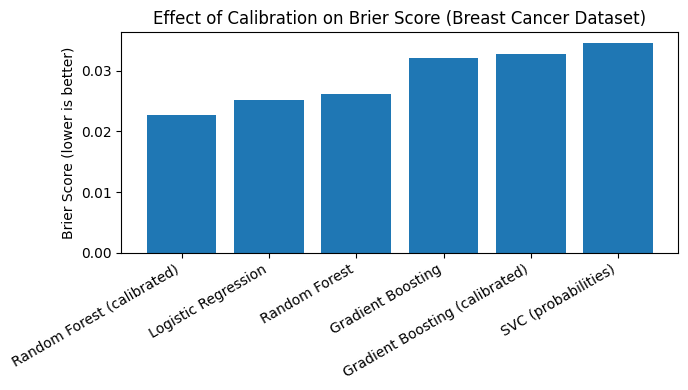

In [7]:
plt.figure(figsize=(7, 4))
plt.bar(df_all_sorted["model"], df_all_sorted["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Effect of Calibration on Brier Score (Breast Cancer Dataset)")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.calibration import calibration_curve

def brier_decomposition(y_true, prob_pred):
    bins = 10
    prob_true, prob_pred_bin = calibration_curve(y_true, prob_pred, n_bins=bins)

    # Calibration error
    cal_error = np.mean((prob_pred_bin - prob_true)**2)

    # Refinement = variance of predictions
    refinement = np.var(prob_pred)

    return cal_error, refinement

for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]

    cal, ref = brier_decomposition(y_test, probs)
    print(f"{name}: Calibration={cal:.4f}, Refinement={ref:.4f}")

Logistic Regression: Calibration=0.2342, Refinement=0.2107
Random Forest: Calibration=0.0716, Refinement=0.2093
Gradient Boosting: Calibration=0.1329, Refinement=0.2287
SVC (probabilities): Calibration=0.0702, Refinement=0.1828


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_cifar = pd.read_csv("../tests/data/measures/brier_score_cifar_resnets.csv")
df_cifar

,model,brier_score
0,ResNet18,1.057578
1,ResNet34,1.161664
2,ResNet50,0.928534


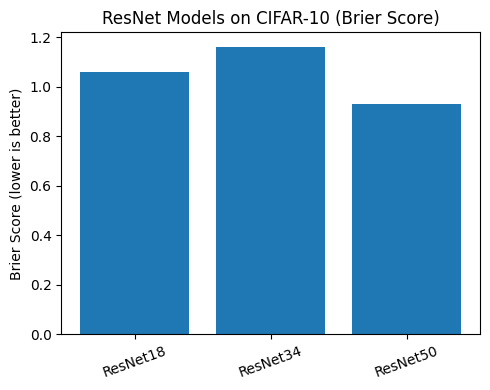

In [2]:
plt.figure(figsize=(5, 4))
plt.bar(df_cifar["model"], df_cifar["brier_score"])
plt.ylabel("Brier Score (lower is better)")
plt.title("ResNet Models on CIFAR-10 (Brier Score)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [3]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt


def show_sample_images_for_model(model_name: str, n: int = 5):
    """
    Display up to n saved CIFAR images for the given model.

    Looks in: tests/data/cifar_images/<model_name>/*.png
    """

    folder = Path("../tests/data/cifar_images") / model_name
    if not folder.exists():
        print(f"No images found for model '{model_name}' in {folder}")
        return

    image_paths = sorted(folder.glob("*.png"))[:n]
    if not image_paths:
        print(f"No PNG images found in {folder}")
        return

    plt.figure(figsize=(3 * n, 3))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(path.name, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Sample predictions – {model_name}")
    plt.tight_layout()
    plt.show()

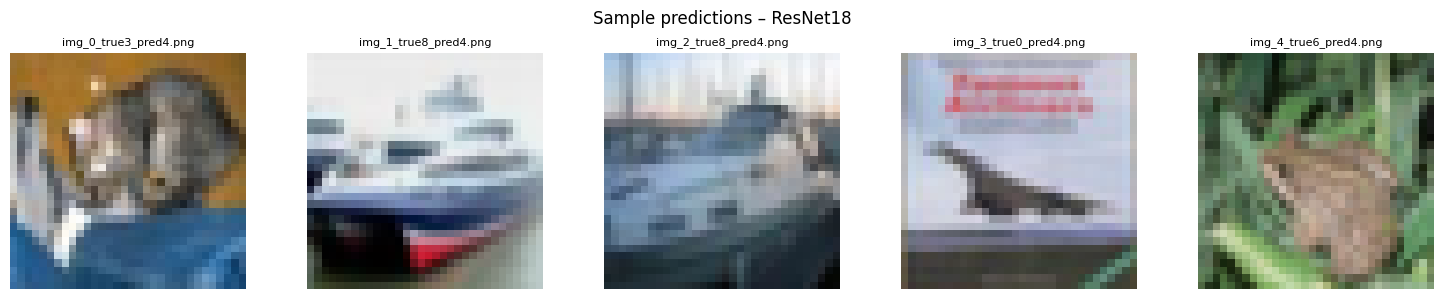

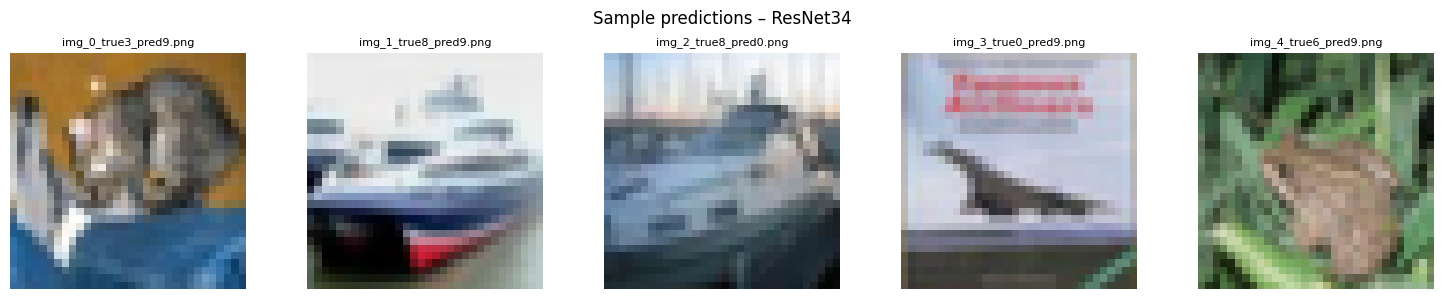

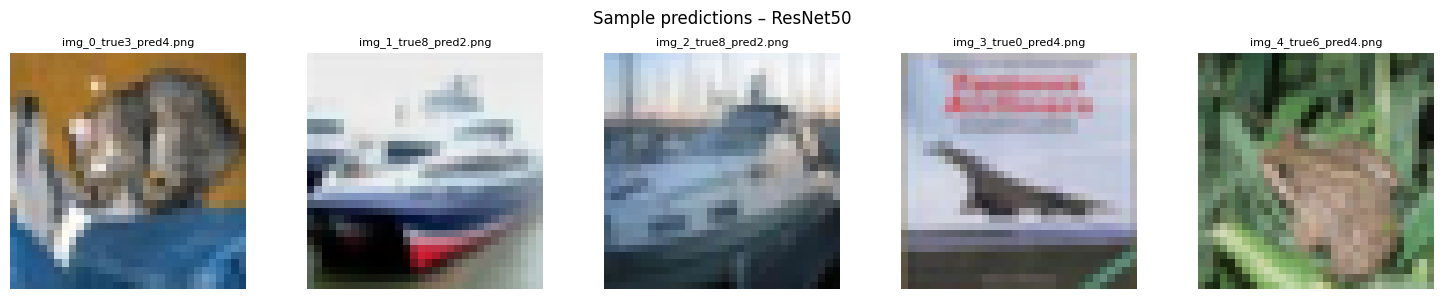

In [4]:
show_sample_images_for_model("ResNet18", n=5)
show_sample_images_for_model("ResNet34", n=5)
show_sample_images_for_model("ResNet50", n=5)

In [5]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt


def show_sample_images_for_model(model_name: str, n: int = 5):
    """
    Display up to n saved CIFAR images for the given model.

    Looks in: tests/data/cifar_images/<model_name>/*.png
    """

    folder = Path("../tests/data/cifar_images") / model_name
    if not folder.exists():
        print(f"No images found for model '{model_name}' in {folder}")
        return

    image_paths = sorted(folder.glob("*.png"))[:n]
    if not image_paths:
        print(f"No PNG images found in {folder}")
        return

    plt.figure(figsize=(3 * n, 3))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(path.name, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Sample predictions – {model_name}")
    plt.tight_layout()
    plt.show()

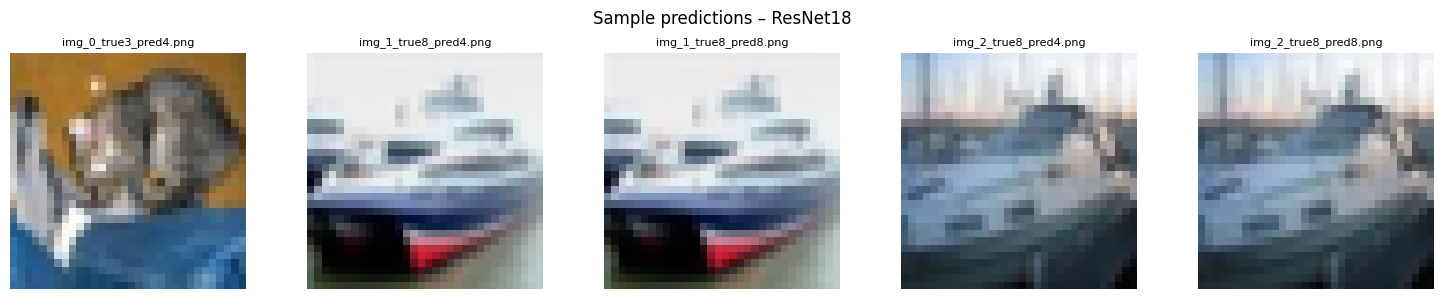

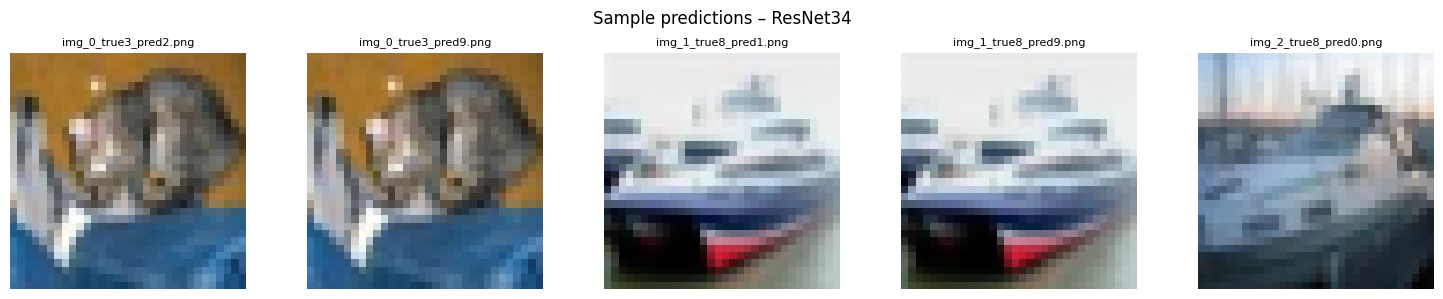

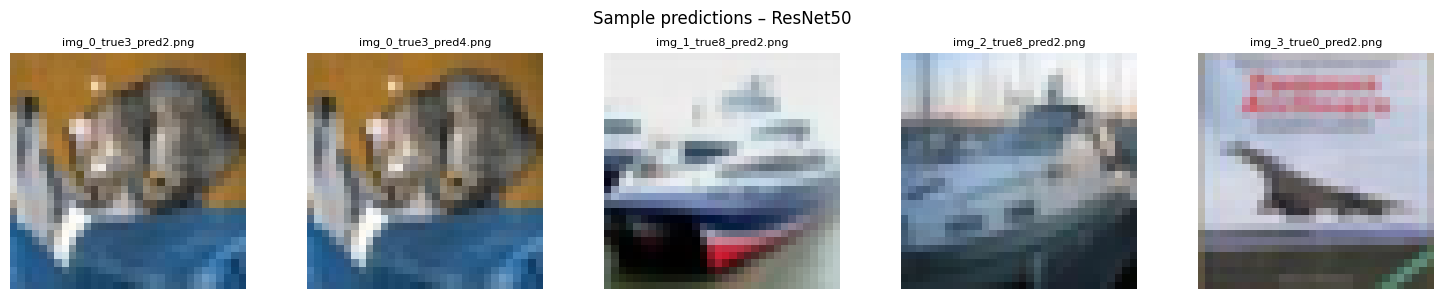

In [7]:
show_sample_images_for_model("ResNet18", n=5)
show_sample_images_for_model("ResNet34", n=5)
show_sample_images_for_model("ResNet50", n=5)